# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [51]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count("!")



    X_quant_features = toxic_data[["word_count", "punc_count",  "excl_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [52]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=99)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))


toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [53]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 6822, 'TN': 56046, 'FP': 58574, 'FN': 6214, 'Accuracy': 0.49247978943410414, 'Precision': 0.10431830693008746, 'Recall': 0.5233200368211107, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [54]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12948, 'TN': 114560, 'FP': 60, 'FN': 88, 'Accuracy': 0.9988406342044244, 'Precision': 0.9953874538745388, 'Recall': 0.9932494630254679, 'desc': 'svm_train'}


### MODEL: logistic regression

In [55]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12987, 'TN': 114570, 'FP': 50, 'FN': 49, 'Accuracy': 0.999224478285392, 'Precision': 0.9961647618317098, 'Recall': 0.9962411782755446, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12787, 'TN': 103271, 'FP': 11349, 'FN': 249, 'Accuracy': 0.9091464561007708, 'Precision': 0.5297895260192244, 'Recall': 0.9808990487879717, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [57]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12933, 'TN': 114506, 'FP': 114, 'FN': 103, 'Accuracy': 0.9983001190700006, 'Precision': 0.991262359163026, 'Recall': 0.9920988033139, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [58]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 11026, 'TN': 114445, 'FP': 175, 'FN': 2010, 'Accuracy': 0.9828836874099142, 'Precision': 0.9843763949647353, 'Recall': 0.8458115986498926, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yiran/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13036, 'Neg': 114620, 'TP': 0, 'TN': 114620, 'FP': 0, 'FN': 13036, 'Accuracy': 0.8978818073572726, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yiran/Desktop/ml_projects/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

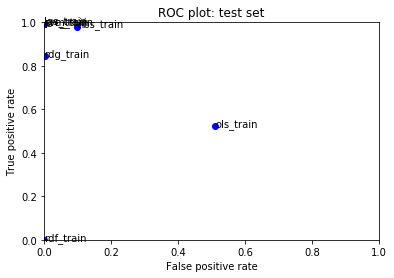

In [60]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [61]:
ols_predictions = ols.predict(X_train)

In [62]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
76
better! 

I'd like to issue a public thank you to the Wikipedia community for their attention to this area.  This article has defiantly shown an improvement and is closer to scientifically accurate after my posts.  It is a big responsibility that Wikipedia has, and that responsibility should be free of cultural bias, even if it may seem to go against what we have been led to believe by American media and culture.

When I first started looking into this topic, the articles I found were woefully inaccurate and defiantly biased.  I still feel that objectively, the definition should clearly state that most cross-breeds lead to a reduction in fitness.  Heterosis can be induced through breeding stragity such as line-breeding but it is a wasteful effort.  Random mixing of genes is similar to random mutation, most of which is deadly and not beneficial to the gene pool.  99% of mutations are deleterious.

Respect of natural selection should be the default positio

2898
I have now added another applicable image. This allows the right-looking image to be placed lower down, where it does not diplace the toc and thus break up the flow. Ihope this is a satisfactory solution.
* * * * * * * * * 
2929
"

""Massacre"" makes the most sense at this time because most of the sources discussing the event have used the term. ""Event"" sound like the circus came to town so that's a non-starter. ""Sack"" is also a non-starter for numerous reasons, chiefly because like ""event"" not one source uses that term.crewer (yada, yada) "
* * * * * * * * * 
2963
See response to Ks0stm (I hope I typed that right) - I do not expect to be unblocked. 86.165.204.5
* * * * * * * * * 
2979
"==GA Review==

:This review is transcluded from Talk:Fashion (film)/GA1. The edit link for this section can be used to add comments to the review.

Reviewer:  (talk · contribs) 

Checklist
Close paraphrasing - The film is more about the story of models, designers and people connected with the

5141
Wertham 

I fail to see what's wrong with what I wrote, it's verifiable and it helps the section to be neutral. Perhaps you could rephrase me better if you don't like the words I used.
* * * * * * * * * 
5142
"

I believe that was in response to Zaroves threats to publish Acharya's credit info online if I didn't back off and let him have his way with the article. Procuring a credit report under false pretenses is a crime. In addition, a wanted kidnapper is known to have passed around Acharya's personal info to religious groups, suggesting that Zarove may have been in contact with this person. Where, for example, did he get the 'Melne' middle name from?? His story has been that he is a former reporter, with a ""masters in journalism"", and that he wrote an article about Acharya for a tennessee newspaper; he says he procured this info in his research efforts. Though he will give his full name, he will not give the name of the newspaper, the title of the article, the date it was publ

7420
Hi, you deleted three links that I inserted - an account of the runner's high on 'Endorphins' and a link to an academic paper directly connected to 'Transcendentalism' and 'Romantic poetry' (title: On Being God). I cannot understand why these would be inappropriate. They are not promoting anyone or selling anything, merely providing a further resource for the topic in question. 

Please reappraise your deletion.

Thanks
* * * * * * * * * 
7436
"
Give me a little bit, and I'll look into this. SWATJester Son of the Defender "
* * * * * * * * * 
7490
Legal formatting 

I'd be interested to know people's views on the formatting of some of this and other articles. I note that since I added detail a few years ago for example, someone had added 'plaintiff' rather than the more commonly used 'claimant', and rather than my explanation of a case which applied the rule in McGhee, simply stated 'applying'. Whilst I understand the law report format of this kind of change, I wonder if wikipedia

10116
Your bot 

Your bot keeps tagging the articles for NowPublic and Examiner.com for using blacklisted links. These were whitelisted for the respective article. I don't know what you need to do on your end to keep your bot from repeatedly putting a tag that isn't needed on the articles, but it needs to stop. It is becoming a nuisance.
* * * * * * * * * 
10167
Additional school history information - year built, reason for building campus, etc.
* * * * * * * * * 
10173
After much testing with a number of oversighters, we have been unable to reproduce the bug (even after I reproduced the post that you made, using my own screen (and redacting the token)).  At the moment, I'm suspecting either a cacheing error, or some confusion about timing and the need to refresh the page to see some updates. I'll ask Keegan to see if he specifically can reproduce, tomorrow, but 3 other oversighters had success. 
(Just FYI, the hide/delete/suppress links are all duplicated on the History page, so even 

12351
And that's with the cultural impacts in their own articles! If the split does happen (and I'd suggest waiting a couple more days for comment) be sure to leave a decent summary of the refecting social issues section to address Newbie's concerns. S/he is correct that it's one of the major aspects that contributes to their popularity and should still be covered here to some extent.
* * * * * * * * * 
12385
Speech condition? 

Any info about his speech condition? How he has overcome it in performing arts? What the condition is, specifically? 24.6.228.145
* * * * * * * * * 
12452
Friendly notification
Please note that Wikipedia is meant to be an encyclopedia, not a personal website or  chat board. Thank you. -
* * * * * * * * * 
12593
"

I'll confess to being a bit lost among these theological discussions. I can say that we should include all significant points of view, even Geaves'. If some say that Rawat had a Sant Mat lineage, while other say he had an Advait Mat or Radhasoami line

14469
I understand your confusion.
* * * * * * * * * 
14480
. Do a Wiki search for Stanford as an example.
* * * * * * * * * 
14540
"
Its not ""one user"" read the 2010 article discussion for such comments. Other users think its about rights not EVENTS. Though deaths are added even though it was dubious at the time. Furthermore get consensus THEN add back per BRD.(  )."
* * * * * * * * * 
14570
OH HOW AWFUL WHAT A TERRIBLE PENALTY I HAVE HAD BANS MORE THAN ENOUGH I HAVE MILLION IP:S BTW
* * * * * * * * * 
14623
NATO & WAR 

Well since there is already an article about the 2nd NATO intervention NATO involvement should not be included in the side box, it can be mentioned but NATO never fought a ground war so I think they should go off. if every one agrees then I will edit that and if we all put our nationalistic egos aside and work together Albanian & Serb maybe we can clean up this article and put truth in it
* * * * * * * * * 
14666
This is my real physical model. Ohms law, is a statis

16833
WP:NPA. You're the vandal.T
* * * * * * * * * 
16850
EPL active 

got references??76.19.149.244
* * * * * * * * * 
16876
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style

I see you may be a New Zealander (or at least, appear to be by your edits).  There are several NZ related Wikipedia pages.

Portal:New Zealand
Wikipedia:New Zealand Wikipedians' notice board
Wikipedia:WikiProject New Zealand

Adding {{User New Zealand}} to your userpage will list you as a New Zealander.

I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk 

19293
This is my first attempt at writing an entire article, feel free to change anything where you see fit.
* * * * * * * * * 
19482
There is no clear reason for this.
* * * * * * * * * 
19519
Yes. As you can see now, the project is just at its start, its structure is not yet fully developed. Let's hope it will become fully fledged in time.
* * * * * * * * * 
19571
"

IRC?
Are you there now?   † "
* * * * * * * * * 
19645
"

 Please do not vandalize pages, as you did with this edit to Kenneth Feinberg. If you continue to do so, you will be blocked from editing.  /A0 "
* * * * * * * * * 
19684
Confused
Why would you accuse me of vandalism for an edit to Sandal (footwear)?
* * * * * * * * * 
19706
Please do not make personal attacks. Wikipedia has a strict policy against personal attacks. Attack pages and images are not tolerated by Wikipedia and are speedily deleted. Users who continue to create or repost such pages and images will be blocked from editing Wikipedia. Thank you.
* * * * 

21444
Web content lifecycle 

Sandbox created for new article on . Please comment. I'm planning to post live this weekend.
* * * * * * * * * 
21484
"

RSSSF file for Baichung's goals: here.  It says ""scored at least 30 goals"", which means there could be more.  Unless you could point out the exact matches where he as scored more that aren't listed in that RSSSF file, then he only has 30 goals.  Having said that, they list I.M. Vijayan as having scored more than Baichung with ""at least 40 goals"", here."
* * * * * * * * * 
21498
It means (I presume) that no evidence was offered in their defence.  (T)
* * * * * * * * * 
21557
Muktananda is a controversial figure and the siddha yoga group has tactfully tried to use the goodwill of bhagawan nityananda to the benefit of their group.Siddha yoga itself has nothing to do with Bhagawan Nityananda who was never assosiated with any religious group.He was wondering yogi not a person who founded any organisation.Many of nityananda's other discipl

23742
Yes, well, the English name has no official standing whatsoever now, and so is redundant as Peking, Bombay or Rhodesia. It's getting moved!
* * * * * * * * * 
23789
Response: I am consistently asking for discussion on the talk page. I am attempting to build consensus, whereas those who are attempting to remove entire sections without communication are warring. 66.108.146.155
* * * * * * * * * 
23840
Discussion at  Talk:Bull of Heaven#Genres
 You are invited to join the discussion at Talk:Bull of Heaven#Genres.  Thanks.    Thank you.
* * * * * * * * * 
23885
I know for a fact that it consists of 60-70% percent voters who supported Hussein Obama, but I did that before and a Wikipedian argued that has nothing to do with being liberal. 76.102.193.102
* * * * * * * * * 
23902
Regarding edits made during October 27 2006 (UTC) to Hinsdale Central High School
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. 

25886
Done some checking, it looks like this is going to end up as a range cite with a note at the end, because different sources are claiming different speeds. The official total seems to vary between 32 and 33 knots, the mathematical formula gives the speed at 34.9 knots, and the user requesting the cite has information stating 31 knots. I'm heading for the library tomorrow in hopes of finding some kind of info on what the USN considered the official speed to be, but if I fail I think that the section will need a reword to account for this discrepancy.  (Talk)
* * * * * * * * * 
25991
"
I have aspberger but i dnt act liek you do, dnt use it as a excuse (talk - contrib) "
* * * * * * * * * 
25995
Please quote me a law from WP:OR that forbids my argument. Don't just say original research. I read the article very carefully and found nothing wrong with the point that I made.
* * * * * * * * * 
26009
"
I have been a proponent of stronger relevancy standards at wp:npov.  But having to prov

28354
Try going here and using this form - it should walk you through the process. Title just needs to say what it is, for instance 'Dwarf cat - Binky.jpg' if the name is Binky, and for the copyright, just select the default and you should be good to go.
* * * * * * * * * 
28367
Then obviously you're not a colonel in the civility police. GWH is on a mission, and it's about time that he was blocked.  Fatuorum
* * * * * * * * * 
28385
I still think it's a bad idea to have the links on all the pages, but some may disagree. However, it's inappropriate for the owner to add the links himself even if done in good faith.  | Talk 16:06, Jun 3, 2004 (UTC)
* * * * * * * * * 
28421
I'm working on it. Thanks for the tip.
* * * * * * * * * 
28436
Hey, Bishonen, what about me?! )
I'd really love your opinion of the argument I had with Jossi yesterday regarding whether or not Rawat called himself saviour of mankind, Perfect Master, the incarnation of God himself, etc. as per the quotes I provided.  Wh

31250
"

Communist or not is not the issue here, map clearly states ""the Soviet Union and its allies"" - in red, and ""Non-aligned and neutral countries"" in green. Yugoslavia was founder and member of Non-aligned movement and therefore the map is inaccurate."
* * * * * * * * * 
31252
"

 inre Wikipedia:Articles for deletion/Aditya Roy Kapoor 

As your concerns are being addressed and the article expanded and properly sourced, might you consider a withdrawal? '''' MICHAEL Q.'' "
* * * * * * * * * 
31262
Really? So did you sneak into legitimate courses at Harvard after attending your local community college to pretend you weren't just a pseudo-intellectual? =P
* * * * * * * * * 
31313
"

 TTP: ""They are not affiliated with the Afghan Taliban of Mullah Omar who are supported by the Pakistani army and state."" 

Hi, while I agree for the most part with the above statement, I have to take issue with a little bit of the wording, as petty as that may seem.  I believe that stating that the 

33746
"
Um, no they're not? For example, of the 14 citations you've made in the article, 5 of them point straight to the game's official website. Not good enough. Several of the others link to obscure MMPORG-related review sites and fan sites. These aren't the best either. If this subject is really notable, you should be able to find sources that are completely dissociated from the game; in fact that are dissociated from video games in general (such as mainstream news articles).  inspect damage⁄berate 

"
* * * * * * * * * 
33763
I've now created A660 road so would be delighted if (A) you could create an icon for the A660, a primary route.  Other A6nn roads which currently have infoboxes with red links are (B) A666, A685, A690, plus A683 is linked from one of those.  Also there's a page with infobox for A6055.   There are other roads which have pages without infoboxes, possibly because there isn't an icon: (C) A605, 607, 612, 614, 625, 628, 630, 631, 635, 636, 638, 642, 647, 686, 6030,

36482
It was not my intention, but I personally wrote those contents too, so they are my own work, anyway.
* * * * * * * * * 
36492
Omer S. Yasin(born February 20, 1996 in Erbil, Kurdistan) is an Iraqian computer programmer and IT. He is studying and working in computer science. In 2001 started school in 2007 finished primary school. In 2008 started secondary school and in 2010 finished school. In 2011 started high school and 2013 finished high school. When he was 13 he started working on software programs. His dream was to built a data center and working at a professional company of computer science. As he was young, he wasn't to smart at school ,but he is smart at computer software.
His father is an mechanical professor at sallahadin university. Prof. Safeen Y. Ezeddin. He was born in 1961. Omer has two brothers. Arsan Safeen and Ali Safin.
Omer is one of the best-known entrepreneurs of the personal computer revolution.
* * * * * * * * * 
36527
Correct, I just removed the category, w

38434
"

SandyDancer

You're not even Maltese, how do you expect to correctly edit a page about a person who's only notable in Malta? Sure, you can rely on articles you find online, but as you may have noticed, pretty much all the media is against Norman Lowell and his party, for obvious reasons. There's even a website dedicated to ""spreading the true agenda"" or whatever  . But of course, everything you read is only partially factual and mostly biased... and rightfully so, but such information has no place on wikipedia. Perhaps you'd be interested in writing a ""criticism"" section? That would make more sense.

On a side note, regarding the banning of Norman Lowell...it is well-known in Malta that Lowell was banned from the media, but unfortunately I could only find one source stating that. The person interviewed in the article is the editor of one of the most popular Maltese websites, www.maltafly.com, on which Lowell has been frequently made fun of.

 

 "
* * * * * * * * * 
38436


40386
"

Thank you for experimenting with Wikipedia. Your test worked, and the page that you created has been or soon will be deleted. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.   T/C "
* * * * * * * * * 
40478
Seems like it. The footnote (well two footnotes actually, one per source) is there anyway, but I think it's important that it stays.  talk
* * * * * * * * * 
40488
Awwww, I've got a wiki-stalker.  I'm flattered at your obsession.  Really!  Now run along.
* * * * * * * * * 
40543
broken mp3 song link
Makedonia ksakusti by a Military Band . mp3 is broken. whoever has the song post it.
* * * * * * * * * 
40550
"

 Listen 

1. Can you please explain to me how a social networking site is ""relevant"" to a conservative encyclopedia?

And

2. Explain to me how if you ''did not know the title' of the following, what it sounds like to you?

Let's say in North Korea they

42475
Update the recent legislation part. 

According to my financial advisor congress had approved some form aid, which is why I was able to get funding for my Summer semester. This means since April 6th they have passed something. Since word of mouth is not a reputable source, can someone find a article about what has happened since then? IN fact, I'll go look for one now.
* * * * * * * * * 
42486
So why has nathan porrit got an article?
* * * * * * * * * 
42501
Stargate Portal 

In response to your message. A bunch of links at the bottom don't make a portal useful. They only clutter it. If you want to make it useful, suggest new ways to improve it, don't just dump a bunch of links in it.
* * * * * * * * * 
42512
"

 That is just plain BS, forgive the wording....if you look at that rule, it is meant for ""empty"" sites that redirect to a site with content. The original URL is to a site with content. User:kalimantan"
* * * * * * * * * 
42559
Leadership conventions 

Thanks. I am also 

44539
"

He stated bottom two. Safe second is equivalent to standing at the final moment before someone is eliminated. Tempest in a teapot, people. Seriously? – (talk) "
* * * * * * * * * 
44610
, 18 October 2006 (UTC)

I give you an alternative definition: White=Caucasoid (source US census, almost any book on racial anthropology that is not written by a Nazi, neo-Nazi or proto-Nazi...).  20:59
* * * * * * * * * 
44706
I've done what I think fair,; I gave the explanations earlier. Perhaps they wil stick. '''''' ( talk )
* * * * * * * * * 
44707
I have no problem with that.  I've been reading the things this guy has been writing about you and et al and I can't believe he's been allowed to get this far for this long.  Unbelievable.  I've been away from the page thinking he would cool down.  But he's as bad as ever.  I'm angry that he went to my talk page and removed materials I had deleted, which is my right to do, and then pasted it up here on the Karl Rove talk page.  Why he gets away 

46295
See..you even admit that the first middle school was a junior high school.  Middle schools originally came from junior high school.  So why can't the article be called junior high school? Why do you still disagree? ( )
* * * * * * * * * 
46304
Gorbachov went to the West with a begging bowl and cap in hand, and was told to go home. The USSR then broke up in what Putin called the biggest geo-political mistake ever. People (in the West) here can make as much fun out of the China and the Chinese as they like, but it is the Russians they have to watch because Russia will soon want its empire back. The all conquering Russians are now even claiming the North Pole as part of their territory. Would you not want the Chinese on your side when this happens?
* * * * * * * * * 
46336
" the Afd reverted on page Gadugi and Karmosin sanctioned for violating wiki/Wales policy of We Are Nice People Who Do Not Act This Way.  On his user page his lists himself as a ""rebel"" which isn't something tha

48416
WP: Edit War re: Roentgenium 

I take issue with being the only protagonist being warned for engaging in an Edit War in regards to Roentgenium. Perhaps you are just warning me because you disagree with me?

I have attempted to reach a compromise position, and that is represented in the history for the page with my good faith edits trying to take into account the other side's objections. The other side refuses to engage in the meat of the discussion as to whether the edit that I (and another) have attempted to put forward.

Instead of swooping in on talk pages of protagonists with whom you (apparently?) disagree, why don't you contribute to the discussion?
* * * * * * * * * 
48479
Please Punya666 while editing on article talk pages edit at the bottom of the page so as not to break the thread, editing here is not like on a talk or comment page where the latest text appears on the top, your editing is very disruptive esp. on talk page, such as making personal attacks on fellow edito

50839
"

 
You have been blocked from editing  for vandalizing . If you wish to make useful contributions, you are welcome to come back after the block expires. ~  "
* * * * * * * * * 
50857
Okay, we have a problem.
* * * * * * * * * 
50870
, 23 April 2008 (UTC)
Sorry, but it has been quoted that beyond all doubt, this article is 15k above and beyond what MoS says is allowable for reader attention. There is a great present need, and if he sees a call for this article to be trimmed as an attack, then he is having WP:OWNing problems and should leave for violating such.   16:27
* * * * * * * * * 
50948
You'll see from my Talk page that the Admin who responded to your and Sir Fozzie's complaint has acknowledged that your attack on me was the result of a misunderstanding. Perhaps it is time now for you to apologise?
* * * * * * * * * 
50964
"

 loudspeakers 

Hi. 
A reliable source has been added on London Muslim Centre.    ''''''  talk "
* * * * * * * * * 
50967
For further info.... 

Ello

52886
"

Hi WLU. I am still up for trying to resolve the dispute. I have to admit that it is getting a bit difficult. Some of the recent interaction on the talk page I have found myself thinking both of you are making good points. I am wondering if it is worth trying to recruit another editor from wiki med to the discussion? | T@1k? "
* * * * * * * * * 
52894
"{|class=""wikitable"" align=right width=40%
!Talk archives
|-
|
2004 and January to March 2005
April and May 2005
June 2005
July 2005
August and September 2005
October and November 2005
December 2005 to February 2006
March to May 2006
June to August 2006
September and October 2006
November 2006 to February 2007
March 2007 to January 2008
February 2008 to November 2008
December 2008 to February 2009
March 2009 to October 2009
|}

"
* * * * * * * * * 
52982
"
 No, the main space is for notable topics that are referenced. If you want to work on the article in this state ask for it to be copied to you userspace. When you have provide

55084
"::::::From the rationales I'm reading here, I don't think ""most"" supporters of the current version consider this to be a minor tweak, but arguendo let's assume they do.  A reasonable argument could have been made to these editors that, as you see a large problem with the proposed edit, and as they see negligible benefit, they might want to stand aside rather than support the change.  That's a delicate argument to make and requires a high level of trust among the editors involved.  I don't see any evidence of that trust here, and so I'm not surprised that argument wasn't successful.   
Now that we've moved from persuasion to determining where the consensus lies, no, it is not appropriate to disregard an opinion because an editor considers the edit in question to be minor.  It is even less appropriate to raise this after several opinions have been posted. tc  

"
* * * * * * * * * 
55124
That advice should be directed to the first saboteur you you follo in his footsteps even aft

Make that two against. Irrelevant msth assignment removed.
* * * * * * * * * 
57195
"

{| width=""100%"" style=""background:transparent;""
{| width=""100%"" style=""background-color:#;border:1px solid #;-moz-border-radius:12px;-webkit-border-radius:12px;""
|style=""width: 50%; border:1px solid #; background-color:#; vertical-align:top;border:1px solid #;-moz-border-radius:10px;-webkit-border-radius:10px;padding:4px;""|
 Hello, Karry145, and Welcome to Wikipedia!

Happy editing!   
{| width=""100%"" style=""background-color:#""
|style=""width: 50%; border:0; background-color:#; vertical-align:top""|
 Getting started Introduction
 The five pillars of Wikipedia
 How to edit a page
 Intuitive guide to Wikipedia Finding your way around Table of contents
 Department directory Editing articles How to develop an article
 Manual of Style
|style=""width: 50%; border:0; background-color:#; vertical-align:top""|
{| width=""100%"" cellpadding=""2"" style=""vertical-align:top; background-color:#""
!

59289
It was already proven that Bucsrsafe is in another continent, he is most likely a lot closer to you than me Simishag.  hganesan
* * * * * * * * * 
59316
"
 LOL, so what was all that about yesterday? Had you not seen the episode when u added the fact tags?  talk "
* * * * * * * * * 
59338
"

Facts

The Kincaid Family originated ALL-OVER Europe. It is generally believed that the Kincaid Family was founded byu Sir William Galbraith, who was granted the lands of Kincaid by King Robert thr Bruce upon William's marriage to an unknown Princess, whom was the daughter of John Comyn III, the ""Black Comyn."" MOST Genealogists agree that this occured, since that is what the documentation support leads to. This unknown Princess was a descendant of Emperor Charlemagne as well as various rulers of Scotland, including David I of Scotland.

I believe that this information should be merged into the article. I just wanted to get comment before I do so. I will add th information in three (3) days. 

61583
"
Hey. I believe that the IP user 72.11.138.103 may be Inkheart again. A few hours ago, the anon made four edits only to stuff Inkheart's sockpuppets use to edit, and followed Inkheart's MO of removing template tags. phois 
Same with anon  phois "
* * * * * * * * * 
61592
"== Wikipedia and copyright ==
 Hello Notsilly, and welcome to Wikipedia. Your addition to Wonderland City has had to be removed, as it appears to have added copyrighted material without permission from the copyright holder. While we appreciate your contributing to Wikipedia, there are certain things you must keep in mind about using information from your sources to avoid copyright or plagiarism issues here.

You can only copy/translate a small amount of a source, and you must mark what you take as a direct quotation with double quotation marks ("") and a cited source. You can read about this at Wikipedia:Non-free content in the sections on ""text"". See also Help:Referencing for beginners, for how to cite sourc

64007
"null ""Of course it's easier if you hold an Olympic Games in the middle of nowhere. I visited Naypyidaw recently, in Burma, they've got six-lane highways and no cars on them. This is a busy, bustling city so inevitably you're going to have challenges.""198.228.201.157  "
* * * * * * * * * 
64024
"

Speedy deletion of Fluro-ninjas
 A tag has been placed on Fluro-ninjas requesting that it be speedily deleted from Wikipedia. This has been done under section A1 of the criteria for speedy deletion, because it is a very short article providing little or no context to the reader. Please see Wikipedia:Stub for our minimum information standards for short articles. Also please note that articles must be on notable subjects and should provide references to reliable sources that verify their content. 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with ad

* * * * * * * * * 
65951
Do not blank me again.  That is a rights violation of Wikipedia users.
* * * * * * * * * 
66016
Are you kidding me?!  Casino Rama has provided hundreds of jobs, and has drastically increased tourism all year round.  Casino Rama is currently being expanded, and a new hotel and recently been built.  It's only getting larger and more important to the Orillian economy.  I should now, I live in this town!
* * * * * * * * * 
66036
Thanks, James! That all looks like good advice. I'll act on it in the fullness of time.
* * * * * * * * * 
66043
You going to claim that this ex parte conversation has any intent other than stirring up trouble for me? First you try BD, now you try this? If anyone's harassing, it's you.
* * * * * * * * * 
66080
Can someone please enter into Nadal's wikipedia page that he is the only player ever to hold 3 majors on 3 different surfaces in the same calendar year?  Rod Laver had a calendar slam but the majors then were played on only 2 differen

67764
"

Oops! Sorry.  You'll have to choose a new username.  Having a username the same as a company gives the impression that yours is a shared account or represents the company.  Shared accounts are not allowed.  You can create a new username by logging out and then clicking on ""Create account"".  —EncMstr (talk) "
* * * * * * * * * 
67771
"

 Removed the ""central planning"" nonsense 
""Central planning in USSR"" refers to centrally planned economy as opposed to the 'free market' economy. While it may be argued as reason for general economic inefficiency of the USSR during its later years it is completely out of place as a reason for space exploration setbacks in this article. First of, it was precisely the central planning that made Soviet space program possible. Without centrally allocated resources and planned activities it would never see the light of day nor would it be able to compete against a similar space program undertaken by the wealthiest nation on the planet. Secondly

70064
"

 Systemic risk 

I have a couple of suggestions for the third paragraph of Debates and controversies'#Systemic risk, aiming to improve the accuracy a bit. The paragraph currently reads, with the problem areas highlighted:

However, as all investors in the herd would lose funds in such a situation, I'd like to tweak the wording a bit to clarify this. Also, the last sentence is simply a restatement of risks already cited in greater detail above. I would suggest cutting to make the section more concise. My proposed revisions are below:

Thoughts from others? Cheers,  (Talk · ) "
* * * * * * * * * 
70261
Thanks for sorting that out - I don't often nominate for deletion, I kind of assumed a bot would trailing close behind... all the best.
* * * * * * * * * 
70369
There is a disturbing trend of WP:Crystal ball edits on other constituncy pages. please wait for the election to add the content.(  ).
* * * * * * * * * 
70374
Well 

Thanks for your well-pointed assertion on my RfC. You s

72768
.  So linguistics may tell us that wiradjuri = No.  It doesn't.  The word means what it does similar to 'sign's' referent = sign, or words mean what they do not what they don't.
* * * * * * * * * 
72836
"
The AfD ended in August, 2007, but the single didn't hit the charts until October, 2007. Unless Billboard's ""Bubbling Under R&B;/Hip-Hop Singles"" doesn't qualify as a ""national music chart,"" then WP:BAND #2 would seem to be satisfied, as I noted in my edit summary when I denied the speedy. Regards,  (TALK) 
On further research: And that could be the answer. Billboard's web site says: Most of the charts in Billboard are either pure sales or radio charts. The only exceptions in which we mingle sales and radio data are two of our signature charts: the Billboard Hot 100 and Hot R&B;/Hip-Hop Songs (as well as two charts based on the same data feeds as the Hot 100: the Hot 100's Bubbling Under chart, which ranks the top 25 titles that have not yet reached the Hot 100, and Heatseek

75423
"The Traditional Latin Mass Society of England and Wales, made of priests and layfolk, recommend Fish Eaters: http://www.latin-mass-society.org/links.htm (and the British SSPX linked to it at the old domain).

Contrary to the ""radical"" nonsense being hurled at it, the very neo-con CatholicCulture.org (formerly PetersNet.net) gives it a ""cautious"" rather than their ""danger"" label http://www.catholicculture.org/sites/site_view.cfm?recnum=1915

Jacob Michael of ""Lumen Gentleman"" calls it ""One of the best Traditional Catholic resource sites on the Internet, period. Tons of information and research on Traditional Catholic teachings, customs, habits, prayers, and anything else you could possibly imagine."" http://lumengentleman.com/index.asp

Tradition In Action links to it: http://www.traditioninaction.org/links.htm

Fr. Jim Tucker of ""Dappled Things"" has linked to it a number of times, Religious Tolerance.org links to it (http://www.religioustolerance.org/rcc.htm), New Yor

77499
"

Speedy deletion of That nigga crackers
 A tag has been placed on That nigga crackers requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a band, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable, as well as our subject-specific notability guideline for musical topics. 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the talk page explaining your position, but be aware that once tagged for speedy deletion, if the a

79900
REDIRECT Talk:Doctor Who: Destiny of the Doctors
* * * * * * * * * 
79903
Mandy Moore 

Hi. Wikipedia is written from a neutral point of view. Some of your edits (such as describing her as hypocritical) are not neutral. Neutrality is particularly important to adhere to closely when dealing with biographies of living people per our biographies of living people policy. It will help substantially if you familiarize yourself with those policies before making further substantial edits to the Moore article. If you have any further questions, please feel free to contact me on my talk page at User talk:JoshuaZ. Thanks.
* * * * * * * * * 
79939
Its okay, I just thought it was ridiculous how much people changed the article over time. Ive seen all 3 films multiple times and all that I removed never mentioned anything about him being on celtic or other teams.
* * * * * * * * * 
79955
December 2008 
 Please stop removing speedy deletion notices from pages that you have created yourself. If yo

82435
"
I've done some more research, and I can't find any justification in the sources I've looked at for calling this quine ""illegal."" Apparently  was the one who inserted the note. I'm kind of new to this, so I'm not sure if there's a process for getting his attention.  "
* * * * * * * * * 
82519
"

 Dianetics confusion 

There seems to be a bit of confusion, or maybe just poorly-constructed passages, about when Dianetics was written and published. The first mention seems to indicate he wrote it in 1950... and that it was then published in 1949. And then later, when it's talking about the ""E-meter"", it mentions a Dianetics enthusiast inventing it in ""the 1940s"". - "
* * * * * * * * * 
82530
"
Really, GB warned me for his actions using following words above: ""::::::This is ridiculous. You say that you are making a fresh start. You say you are moving on. Then you do log out to do this. Or are you now going to claim that isn't you and continue to claim that you are nothing to do

85073
Thanks 

Thank for removing Scott Clemmensen's bio from the the Lowell Devils roster page!
* * * * * * * * * 
85111
You're welcome, and no, I don't believe that being a Outreach sysop should be added, since it isn't relevant.
* * * * * * * * * 
85113
"

Thanks for the kind words. That means alot. I have strong will-power. Plus I just need to stay focused. I have problems with not being able to do that. If I stay focused, I'll get more than a ppv done in a month. Crap I did what you see here  and  in one day with no sleep the night before. Stayed up for 24+ plus, not because I wanted to, but because I couldn't sleep. Did not pay attention and still got this down.C "
* * * * * * * * * 
85147
"
 File:Revolution Radio Banner.jpg listed for deletion 
A file that you uploaded or altered, File:Revolution Radio Banner.jpg, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if

Support. Same reason as .  07:44, 26 Apr 2005 (UTC)
* * * * * * * * * 
87427
There are Gandhinagar and Bhubaneshwar, that are planned and modern Indian cities, so Chandigarh is not the only planned city even in India.
* * * * * * * * * 
87429
Expertise? I hope you're not suggesting I've become the go-to admin for topic  bans? Dreadful fate. Either AN or ANI would work. Theoretically, community topic ban proposals are supposed to go on AN, because they're not about one incident, and because AN isn't archived as quickly. But the preference for AN is becoming more and more a dead letter. In practice proposals for topic bans are often put on ANI, perhaps because it gets more traffic, or perhaps sometimes because it's the only admin noticeboard the OP knows about. 

However. The user seems to have resigned themselves to consensus and is apparently on board with the DR being closed. In such a situation, you're never going to get a topic ban just because they're rude. It's rather strange the 

89127
Normally I would but this unnecessary annoyance has been replaced by a bot. Few, if any, other sites require manual signing. Also you need to delete the whole entry, then give the reason to the poster so he can repost without the contact info. Otherwise he may not repost and the rest of us are then left in a quandary over his original post not providing an alternate method of contact. Also since the Wikipedia provides for email contact of all users if they add it to their preferences your job is to inform them of this instead of PLAYING GOD.
* * * * * * * * * 
89158
. I clearly provided evidence as proof of such behavior. Furthermore, my concerns that [user|Grandmaster] was making an invalid point were completely ignored in the AE discussion. This is nonsense and a shame
* * * * * * * * * 
89192
"

 BLP violations in the Roman Polanski article. 

The WP:BLP states ""If an allegation or incident is notable, relevant, and well-documented by reliable published sources, it belongs in

91349
"
I placed the tag because someone wrote blatantly on the top of the article, ""This entire article biased and in clear violation of the spirit of neutrality of Wikipedia."" talk contribs "
* * * * * * * * * 
91362
"Alternate Kanji==  
 ""先聖"" also translates to ""Sensei"", but literally means ""anicent sage"" or ""Confucius"".  

It translates to “sensei”? It’s pronounced that way, but it translates (into English, at any rate) as “ancient sage” and usually refers to Confucius. But it has absolutely nothing to do with the word covered by this article, and the kanji are not alternates for 先生. The coincidence of pronunciation is just that: a coincidence. Nothing more, nothing less.   

I'm only asking if the kanji I listed is a archic version of the current kanji used. Plus, Confucius was a teacher so it can't be said mere coincidence.  

Suite yourself. But 先聖 is not an archaic version of 先生, and the coincidence of pronunciation is just that. This is not at all a rare phenomenon i

* * * * * * * * * 
93724
Out of all my  guarantee's,
* * * * * * * * * 
93748
New Jersey also now has a JJ in New Brunswick, NJ, making the map inaccurate.
* * * * * * * * * 
93763
"
Note that technically, as a result of our transition to CC-BY-SA, a link to the original article is enough to satisfy the license. However, I agree that, as a courtesy, the Vietnamese Wikipedia should be better about explicitly crediting the source wiki in translations. In the past, I would simply add an interwiki and state Dịch từ Wikipedia tiếng Anh (""Translated from the English Wikipedia"") in the first edit's summary. Do you happen to know how other wikis tend to do this, especially wikis with fewer than 100,000 articles (since they primarily translate)? –  (talk, contribs) "
* * * * * * * * * 
93793
Hello Zeizmic, welcome to the 'pedia! I hope you like the place and decide to stay. If you ever need editing help visit Wikipedia:How does one edit a page and experiment at Wikipedia:Sandbox. If you need 

96236
Take your grudges elsewhere.
* * * * * * * * * 
96244
"

 Kidnap (2015 film) 

Please move Draft:Kidnap (2015 film) to Kidnap (2015 film) - Thanks.  «T ♦ C ♦ » "
* * * * * * * * * 
96258
I would support the removal of the split template as the split suggestion was about the infobox. However I have since changed the infobox to be more status neutral and I have added relevant UNMIK information. So now we basically have what was in the three previous infoboxes all in one now.
* * * * * * * * * 
96275
" ''' 《Defender of Open Editing》''' "
* * * * * * * * * 
96302
Why don't you delete all the sock puppet edits at Great power, too?
* * * * * * * * * 
96390
Re: Charlotte Catholic High School
* * * * * * * * * 
96427
So far, the critical articles are directed at Mass Effect PC from having it, not Spore. ie, Spong
* * * * * * * * * 
96588
"

 Your personal attacks 
This is to advise you to refrain from posting false allegations about  supposedly using sock-puppets or being someone's sock-

98677
"

Pending changes
This article is one of a  number selected for the early stage of the trial of the Wikipedia:Pending Changes system on the English language Wikipedia. All the articles listed at Wikipedia:Pending changes/Queue   are being considered for level 1 pending changes protection.

The following request appears on that page:

Comments on the suitability of theis page for ""Pending changes""  would be appreciated.

Please update the Queue page as appropriate.

Note that I am not involved in this project any much more than any other editor, just posting these notes since it is quite a big change, potentially

Regards,  Farmbrough, ."
* * * * * * * * * 
98691
From the Sandbox...
Ger a load of this: Look at the left side.
* * * * * * * * * 
98760
"

Exactly. They tend to be thinnish and highly tapered, with little or no overtone if played towards the rim. My Wuhan 14"" Fast Crash has quite a thick bell, capable of some lovely pianissimo ride patterns using a nylon tip (7N or

100623
You have published books and then you have university books on campus. I assume they were publishing books for the university before publishing books to the public for sale. There are books on campus that I have seen in my college library dating back to 1080 in Latin and English. Books with wooden covers and handwritten that are published sit in the libaries everywhere.
* * * * * * * * * 
100734
"
I think that's the best move for now. The article can always be moved later. I'll have to look at how Wikipedia handles authors - whether they have the articles under pen names or actual names.  Talk "
* * * * * * * * * 
100748
"

 Reversion of edit to ""Text Messaging"" 

I believe you made a mistake in reverting my edit.

The correct word in the sentence should be ""genera"", as in the plural of ""Genus"", as in Kingdom, Phylum, Clade, Order, Family, Genus, Species."
* * * * * * * * * 
100818
About a week ago a user deleted the lists on this page citing copyright, although reading th

103077
Dave Wain says: There was no disruptive editing after 24 hours, other than to complain about your disruptive criticisms. My additions were completely valid updates to swash plates - accurate and interesting. If you continue to stop inventors from adding content, your reputation will be one of establishment bullies trying to rig the market.
* * * * * * * * * 
103081
"

  You have been  blocked from editing for a period of 31 hours for vandalizing Wikipedia. If you wish to make useful contributions, you are welcome to come back after the block expires. (talk)   "
* * * * * * * * * 
103156
Saying it is a 'professed status' is ponderous reasoning. Their beliefs are verifiably Christian. If they said 'we are Christian' but were really worshipping the Flying Spaghetti Monster, then the article should not say they are Christian. Because they believe that Jesus was the Messiah, the son of God, and they follow his teachings as they understand them, they are indisputably a Christian relig

105709
The Goldman Sach's put is a loan.
* * * * * * * * * 
105847
"
It's an important aspect of the game; Gnangarra is right, the GA nomination would not succeed with the current status of certain sections in the article. 64 "
* * * * * * * * * 
105849
Longest Monosyllabic 

Squirrelled, anybody?  Pronounced sk + world
* * * * * * * * * 
105850
"

And this is an opinion of a PhD student at the University of Maryland? Surely Wikipedia can do better than that, for example already mentioned Cliohres, the European Network of Excellence organized by a group of 45 universities has a lot to say about the subject. Other than that, the most of ""discrimination in Estonia"" google scholar returns are about 'anti-discrimination and equal pay provisions into Estonia's labor laws' and about 'the alleged discrimination' etc.  "
* * * * * * * * * 
105876
No, I'd guess you aren't have many African Americans in Europe.  But now that one has become the President of the United States, perhaps the term w

108210
"

 Yes, it is trashed by you 

When there is link of very reliable source, then whatis   wrong with you to delete it Zora?

Be nice and calm one, if there is anything come and discuss here. You are well-aware of the policies then why aren't you following them? Don't become ""obscure"" one, for us."
* * * * * * * * * 
108251
I just explained to you. They outline some of the school's major traditions and provide an excellent background section created by several people attending the school and various alummini. Universities are all about traditions and enterprising events and passing on/creating as many different accepted activities as possible. I'm surprised that this was even an issue to bring up. I don't think you realize how important these things are to Queen's specifically because you probably aren't a current student or did not attend the school, but they do merit inclusion into the article.
* * * * * * * * * 
108390
In broad strokes, this looks like the right kind of outl

110245
(My silly oversight.)
* * * * * * * * * 
110248
" ""‘Gawi targets ‘four-peat’""]"
* * * * * * * * * 
110271
February 2006

Please stop deliberately introducing incorrect information into articles. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.
* * * * * * * * * 
110274
"

Hi, thanks for your comments, they will definitely be helpful in getting the article to a point where it's appropriate for more general audiences and not just trained linguists. To answer some of your specific questions:
 fómhar has [u:] in some dialects because the rule that mid vowels are raised to high vowels before nasals (including the formerly nasal mh) applies to ó in many dialects. This reminds me that I didn't discuss that raising in the article at all, so I'll add a new section about it presently.
 F and bh/mh/v are often pronounced with the bilabial fricatives  instead of the labiodental [f, v]. Unfortunately, the published sources aren't very specific about 

112442
Then it was an unnecessary move. You can't have it both ways.
* * * * * * * * * 
112455
Excuse me anyone 

 {{unblock| I recently returned from an around the world trip with my wife to find out someone has blocked my account. Is there any way to undo this? thanks Tim Murphy \m/ Peoplesman55 \m/ }
* * * * * * * * * 
112471
Yes I remember reading that also.  it seemed somewhat fishy to me that the indian navy got lucky within hours of the war breaking out.  I will see if I can fiind it. another theory I had read was that actually the sailors on Ghazi had defected to India and the boat was subsequently scuttled by the navy.  this story about the sinking was popularized to protect the families of sailors who were still in Pakistan.  now you know where Tom Clancy got his idea for 'Hunt for Red October' ;-)
* * * * * * * * * 
112504
slow the VFDTOAFD bot down? 

Hello,

Would it be possible to slow the VFDTOAFD bot down?  It's not overwhelming the bandwidth or resources of Wikipedia, 

115162
It is not legal to remove editions on talking page when it is just fakt, question or like that. Stop hunting for sokpupets start follow good manner.74.213.188.138
* * * * * * * * * 
115182
"

Hehe thanks! 22,000 edits is also a sign of greatness. Well done, and keep up the good work! drama "
* * * * * * * * * 
115240
"

By the way, you have to answer those questions before I add it to the main RfA space (I think) I didn't peruse those instructions.  ) ε*  (talk) "
* * * * * * * * * 
115322
I'm pretty sure you're not allowed to hide genres...just say Pop Punk/Various subgenres.
* * * * * * * * * 
115349
"releases and being featured on compilation albums is not, in my best opinion, a candidate for speedy deletion. In order to meet the A7 criterion, the article must give no ""indication of why the band is important"". The albums and compilations are, at least, an indication. Whether or not the band then meets WP:BAND is a separate question, but that is not to be handled by a speedy

117594
"

 ZP5 

ZP5 is, in my opinion, a waste of time for GW related articles. He calmed down somewhat after his block, but is back to ""normal"" now. In the absence of admin action, I fear that the RFC route is inevitable. Comments?   "
* * * * * * * * * 
117620
"

 Civility 

Hi! Could we discuss my ""changed position on civility"" a little? ""No thank you"" is a quite acceptable answer  but I don't think I did change my position, so perhaps I've not expressed myself clearly enough. ∇∆∇∆ "
* * * * * * * * * 
117660
Please stop your disruptive editing. If you continue to vandalize Wikipedia, as you did at Shirley Bassey, you will be blocked from editing.  It's the lead, meant to be a quick summery of the articles contents. Also, you have been obviously using more than one IP here, and the only reason you keep changing this is based on your own POV agenda.   
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid furth

119972
March 2009 
 Please stop your disruptive editing. If you continue to vandalize Wikipedia,  you will be blocked from editing.  — Malik Shabazz (talk · contribs) 
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices.
* * * * * * * * * 
120007
Hi LP, I've reverted most of your edits to José Ramos-Horta.  Please read Wikipedia:Manual of Style (dates and numbers) before changing any more date formats.  Regards,
* * * * * * * * * 
120032
"
It won't be long, this misuse of tools will soon be resolved, this INVOLVED and policy-fail block will be the end of the beginning for so-called ""admin"".   "
* * * * * * * * * 
120037
Look, ducking the question doesn't help. I'll ask again: Must we supply citations that the Easter Rising happened in 1916? Just because you don't happen to know doesn't make it not widely known. Please don't be cowardly and answer this question.
* * * * * * * * * 
120093
Th

122217
Nasib Mukhtarov
  17:33, 15 September 2015‎  (UTC)
* * * * * * * * * 
122220
"

 It's hardly libel, nor is it revenge. I don't even recall a google cache that you got deleted. (Please provide the ref to satisfy my curiosity.) No, this is about circumventing a topic ban by creating a sock. That's all. I happen to hate sockpuppetry and fight it when I see it. You aren't the only one. I often go after socks and hunt them down and make sure they get what they deserve. It's not about admins or not. It really makes no difference. You screwed up royally by using a sock. Your defenses here have only dug your hole deeper by showing you don't understand the seriousness of that offense, and of the reasons for your topic ban. You keep blaming others instead of seeking to understand and promise to reform. I have seen many a blocked editor succeed in getting their block overturned at the last minute by showing they had the ability to learn from their mistakes, take full responsibility for the

124512
Assembly of the Western European Union (WEU)
... of the Assembly of the Western European Union, which was founded in 1955.
In addition to the WEU’s ten member states, they include associate members, ...
 - 5k - Cached - Similar pages 

Guide to the Amsterdam Treaty
... and implemented at the EU’s request by the Western European Union (WEU), ...
Any decision requires the positive votes of at least ten Member States ...
www.europeanmovement.ie/am_gd9.htm - 24k - Cached - Similar pages 

Documento sin título
... were invited to join the Western European Union (WEU) established by Belgium,
... The WEU, including ten Member States which signed the Brussels Treaty ...
www.investing-in-europe.com/en/html/histo_2.htm - 12k - Cached - Similar pages 

The NATO-Russia Archive - New European Security Architecture
... The Western European Union (WEU) was first established as a mutual assistance
... of its ten member states, all of which are both NATO and EU members. ...
www.bits.de/NRANEU/Eu

127049
exactly engaging in good faith here.
* * * * * * * * * 
127073
Actually, that's gone now; you're the only one naming him now. ∇∆∇∆
* * * * * * * * * 
127112
Recording odors 
Will we be able to record odors in the future, like we can do now with sounds and images? 207.69.139.138
* * * * * * * * * 
127159
Thank you. I am glad that we could sort this issue out. )
* * * * * * * * * 
127235
Your repeated removal of content on Lund University 

Hello. Please stop removing content from the article. The guideline you are referring to (Wikipedia:Manual of Style/Words to watch) is about unsourced puffery, and does not apply here. Also please note that you, per WP:BRD, if you are reverted are to take it to the talk page of the article and get support for it there, before removing it again. As a personal comment I would also like to add that an IP belonging to one university trying to downplay another university on Wikipedia does not look good.   talk
* * * * * * * * * 
127253
Why is this a

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [63]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 1674, 'TN': 14023, 'FP': 14703, 'FN': 1515, 'Accuracy': 0.4918376938743538, 'Precision': 0.10221652317274225, 'Recall': 0.5249294449670743, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [64]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2077, 'TN': 27239, 'FP': 1487, 'FN': 1112, 'Accuracy': 0.9185649381168729, 'Precision': 0.5827721661054994, 'Recall': 0.6513013483850737, 'desc': 'svm_test'}


### MODEL: logistic regression

In [65]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2071, 'TN': 27104, 'FP': 1622, 'FN': 1118, 'Accuracy': 0.9141469528434906, 'Precision': 0.5607906850798808, 'Recall': 0.6494198808403888, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [66]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2088, 'TN': 23720, 'FP': 5006, 'FN': 1101, 'Accuracy': 0.8086479711734295, 'Precision': 0.2943332393572033, 'Recall': 0.6547507055503292, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [67]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2104, 'TN': 27124, 'FP': 1602, 'FN': 1085, 'Accuracy': 0.9158076139746201, 'Precision': 0.5677280086346466, 'Recall': 0.6597679523361555, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [68]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 1754, 'TN': 28421, 'FP': 305, 'FN': 1435, 'Accuracy': 0.9454801817327275, 'Precision': 0.8518698397280233, 'Recall': 0.5500156788962057, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [69]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 0, 'TN': 28726, 'FP': 0, 'FN': 3189, 'Accuracy': 0.9000783330722231, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

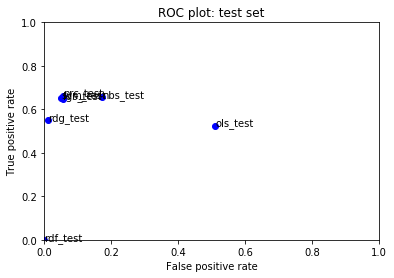

In [70]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [71]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=99, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  excl_count
0          72          10           0
1          13           1           0
2          16           0           0
3          38           3           0
4           7           1           0


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [72]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.15243790969157242


In [73]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [74]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [75]:
my_submission.shape

(153164, 2)

In [76]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation